<a href="https://colab.research.google.com/github/aimbsg/EVA4_S15/blob/master/EVA4_S15_Custom_Dataset_Depth_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
from tqdm import notebook
# -----------------------------------------------------Main Function which calls everything--------------------------------------------------------------
def CustomDataSet(train_split = 70,test_transforms = None,train_transforms = None):

  dataset = Customdata(url="/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg" )
  train_len = len(dataset)*train_split//100
  test_len = len(dataset) - train_len 
  print(len(dataset))
  train_set, val_set = random_split(dataset, [train_len, test_len])
  train_dataset = DatasetFromSubset(train_set, input_transform = train_transforms, output_transform = test_transforms)
  test_dataset = DatasetFromSubset(val_set, input_transform = train_transforms, output_transform = test_transforms)

  return train_dataset, test_dataset



# --------------------------------------------------------------Custom data set-------------------------------------------------------------------------

class Customdata(Dataset):
    def __init__(self,url):
        self.data = []
        self.target = []
       
        self.url = url
        
        fg_bg_batch = []
        fg_bg_mask_batch = []
        for i in range(10000):
          fg_bg_batch.append(f'{url}/fg_bg/batch_1/fg_bg_{str(i+1)}.jpg')
          fg_bg_mask_batch.append(f'{url}/fg_bg_mask/batch_1/fg_bg_mask{str(i+1)}.jpg')

        print("Batch 1 created for 100K images")
      
        
        for i in notebook.tqdm(range(10000)):
          
         fg_bg = Image.open(fg_bg_batch[i])
         fg_bg_array = np.asarray(fg_bg)
         self.data.append(fg_bg_array)  
         fg_bg_mask = Image.open(fg_bg_mask_batch[i])
         fg_bg_mask_array = np.asarray(fg_bg_mask)
         self.target.append(fg_bg_mask_array)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.target[idx]
        img = data     
        return data,target



# ----------------------------------------------------Data subset which comes after splitting--------------------------------------------------

class DatasetFromSubset(Dataset):
    def __init__(self, subset, input_transform=None, output_transform = None):
        self.subset = subset
        self.input_transform = input_transform
        self.output_transform = output_transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.iptransform:
            x = self.input_transform(x)
            y = self.output_transform(y)
        return x, y

    def __len__(self):
        return len(self.subset)

In [0]:
import albumentations as A
import albumentations.pytorch as AP
import numpy as np

class AlbumentationTransforms:
  def __init__(self, transforms_list=[]):    
    transforms_list.append(AP.ToTensor())
    self.transforms_new = A.Compose(transforms_list)
  
  def __call__(self,img):
    img = np.array(img)
    img = self.transforms_new(image = img)['image']
    return img

In [1]:
import albumentations as A
import cv2
fg_bg_means = (0.61764478, 0.67239011, 0.56870159)
fg_bg_std = (0.2542491, 0.24408717, 0.26763059)
mask_means = (0)
mask_std = (255)

train_transform = AlbumentationTransforms([                                                                                                    
                                      A.Resize(64,64),
                                      A.Normalize(mean=fg_bg_means, std=fg_bg_std),                                   
                                       ])
mask_transform = AlbumentationTransforms([                                                                                                  
                                      A.Resize(64,64),
                                      A.Normalize(mean=mask_means, std=mask_std),                                                                   
                                       ])

train_dataset , test_dataset= RawDataSet(train_split = 70,test_transforms = mask_transform,train_transforms =train_transform )

Batch 1 created for 100K images


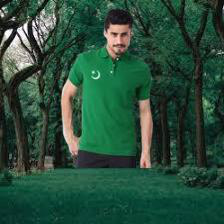

In [6]:
from PIL import Image
a = Image.open("/content/gdrive/My Drive/EVA4_S14_S15/input_data/jpeg/fg_bg/batch_1/fg_bg_2.jpg")
a

In [0]:
import data_loader
trainloader, testloader = data_loader.load(train_dataset,test_dataset,batch_size=256)

In [0]:
import backbone as model
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.Custom_ResNet().to(device)
summary(model, input_size=(3,256,256))

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
criterion = nn.BCEWithLogitsLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=25, steps_per_epoch=len(trainloader),anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, final_div_factor =10)

In [13]:
from model_trainer import train_model
train_model(model,device,trainloader,testloader,optimizer,criterion,1,scheduler,batch_scheduler=True,best_acc = 0,path = "train_225_epochs.pt")

    0%|          | 0/257 [00:00<?, ?it/s]Epoch: 201 LR: 0.009120108393559095
Loss1=1.6979713439941406 Batch_id=256 Accuracy=30.84: 100%|██████████| 257/257 [00:57<00:00,  6.77it/s]
Loss2=1.701568841934204 Batch_id=256 Accuracy=32.75: 100%|██████████| 257/257 [00:59<00:00,  6.61it/s]



 0%|          | 0/257 [00:00<?, ?it/s]Epoch: 202 LR: 0.009120108393559095
Loss1=1.6979742858931404 Batch_id=256 Accuracy=31.76: 100%|██████████| 257/257 [00:57<00:00,  6.77it/s]
Loss2=1.70151978044200 Batch_id=256 Accuracy=32.80: 100%|██████████| 257/257 [00:59<00:00,  6.61it/s]


 0%|          | 0/257 [00:00<?, ?it/s]Epoch: 203 LR: 0.009120108393559095
Loss1=1.6979713439941406 Batch_id=256 Accuracy=31.90: 100%|██████████| 257/257 [00:57<00:00,  6.77it/s]
Loss2=1.701568841934204 Batch_id=256 Accuracy=32.27: 100%|██████████| 257/257 [00:59<00:00,  6.61it/s]


 0%|          | 0/257 [00:00<?, ?it/s]Epoch: 204 LR: 0.009120108393559095
Loss1=1.6979713439941406 Batch_id=256 Accuracy=33.74: 100%|██████████| 257